In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sin, cos, atan, radians, degrees, sqrt

In [2]:
# The pacejka magic formula
def pacejkaMF(slip, B, C, D, E):
    '''
    slip = slip ratio (from -100 - 100), or angle (-90 to 90)

    B = define the width of the peak + how sharp it is

    C = define the height of the peak

    D = vertical scale of the shape
    
    E = how sharp it drops after peak
    '''
    Bx = B * slip
    return D * sin( C * atan( Bx - E * ( Bx - atan(Bx) ) ) )

In [3]:
# let's graph it
pacejkaFV = np.vectorize(pacejkaMF)
slip_range = np.linspace(-100.0, 100.0, num=1000)
W = 4500 # 4500 N

B = 0.29
C = 1.35
D = 1.0
E = -0.1

Flong = pacejkaFV(slip_range, B, C, D, E) * W
Flong_50 = pacejkaFV(slip_range, B, C, D, E) * W * 0.5
Flong_25 = pacejkaFV(slip_range, B, C, D, E) * W * 0.25
max_Flong = np.max(Flong)

result = np.where(Flong == max_Flong)
optimal_slip = slip_range[result[0]]

# for the lateral
slip_angle_range = np.linspace(-90.0, 90.0, num=1000)

Blat = 0.7
Clat = 1.2
Dlat = 1.0
Elat = -0.4

Flat = pacejkaFV(slip_angle_range, Blat, Clat, Dlat, Elat) * W
Flat_50 = pacejkaFV(slip_angle_range, Blat, Clat, Dlat, Elat) * W * 0.5
Flat_25 = pacejkaFV(slip_angle_range, Blat, Clat, Dlat, Elat) * W * 0.25
max_Flat = np.max(Flat)

result = np.where(Flat == max_Flat)
optimal_angle = slip_angle_range[result[0]]

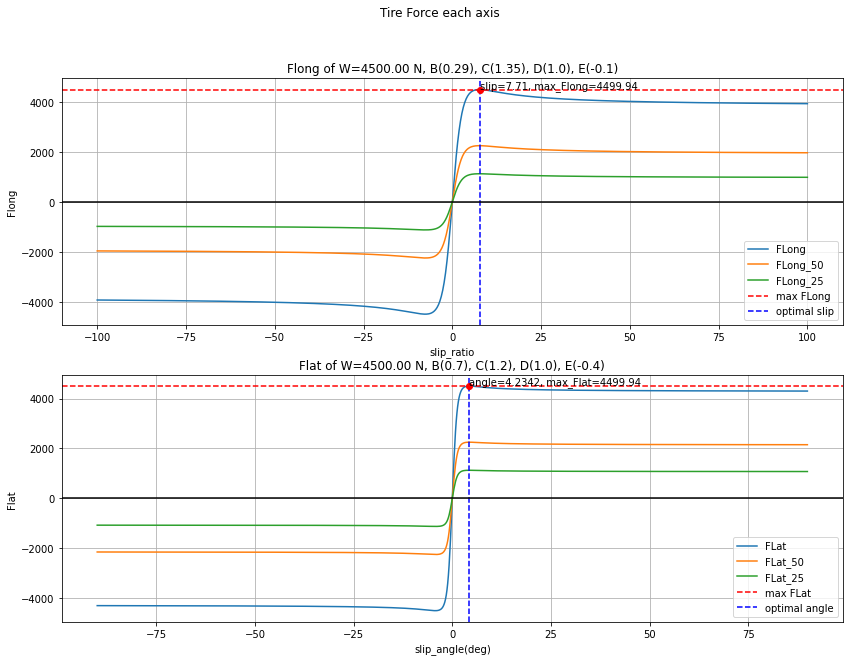

In [4]:
%matplotlib inline
# fig = plt.figure('Pacejka Tire Calculator', figsize=(10, 6))
fig, axs = plt.subplots(2, figsize=(14,10))
fig.suptitle('Tire Force each axis')

# plot the function curve
axs[0].plot(slip_range, Flong, label='FLong')
axs[0].plot(slip_range, Flong_50, label='FLong_50')
axs[0].plot(slip_range, Flong_25, label='FLong_25')
# # plot the axis horizontal line for max_Flong
axs[0].axhline(max_Flong, color='r', linestyle='dashed', label='max FLong')
# # plot the vertical line for optimal slip
axs[0].axvline(optimal_slip, color='b', linestyle='dashed', label='optimal slip')

# # draw marker at maxima
axs[0].plot(optimal_slip, max_Flong, 'ro')
axs[0].text(optimal_slip, max_Flong + 64, "slip=%.2f, max_Flong=%.2f" % (optimal_slip, max_Flong) )

axs[0].set_title(f"Flong of W={W:.2f} N, B({B}), C({C}), D({D}), E({E})")
axs[0].set_xlabel('slip_ratio')
axs[0].set_ylabel('Flong')
# # zero axis
axs[0].axhline(0, color='k')
# # plt.axvline(0, color='k')
axs[0].grid()
axs[0].legend(loc='lower right')

# LATERAL VERSION
axs[1].plot(slip_angle_range, Flat, label='FLat')
axs[1].plot(slip_angle_range, Flat_50, label='FLat_50')
axs[1].plot(slip_angle_range, Flat_25, label='FLat_25')
# # plot the axis horizontal line for max_FLat
axs[1].axhline(max_Flat, color='r', linestyle='dashed', label='max FLat')
# # plot the vertical line for optimal slip
axs[1].axvline(optimal_angle, color='b', linestyle='dashed', label='optimal angle')

# # draw marker at maxima
axs[1].plot(optimal_angle, max_Flat, 'ro')
axs[1].text(optimal_angle, max_Flat + 64, "angle=%.4f, max_Flat=%.2f" % (optimal_angle, max_Flong) )

axs[1].set_title(f"Flat of W={W:.2f} N, B({Blat}), C({Clat}), D({Dlat}), E({Elat})")
axs[1].set_xlabel('slip_angle(deg)')
axs[1].set_ylabel('Flat')
# # zero axis
axs[1].axhline(0, color='k')
# # plt.axvline(0, color='k')
axs[1].grid()
axs[1].legend(loc='lower right')

plt.show()

In [5]:
# define the new pacejka using ratio as parameter
def longPacejka(ratio, Fz=1.0):
    slip_ratio = optimal_slip * ratio
    return pacejkaMF(slip_ratio, B, C, D, E) * Fz

def latPacejka(ratio, Fz=1.0):
    slip_angle = optimal_angle * ratio
    return pacejkaMF(slip_angle, Blat, Clat, Dlat, Elat) * Fz

def combinedSlip(s, a, Fz=1.0):
    rho = sqrt(s*s + a*a)
    Fx = s / rho * longPacejka(rho, Fz)
    Fy = a / rho * latPacejka(rho, Fz)
#     print("%.2f, %.2f" % (Fx, Fy))

    return sqrt(Fx**2 + Fy**2)

print("Combined slip (1, 1) = %.2f" % (combinedSlip(1, 1)))

Combined slip (1, 1) = 0.99


<IPython.core.display.Javascript object>


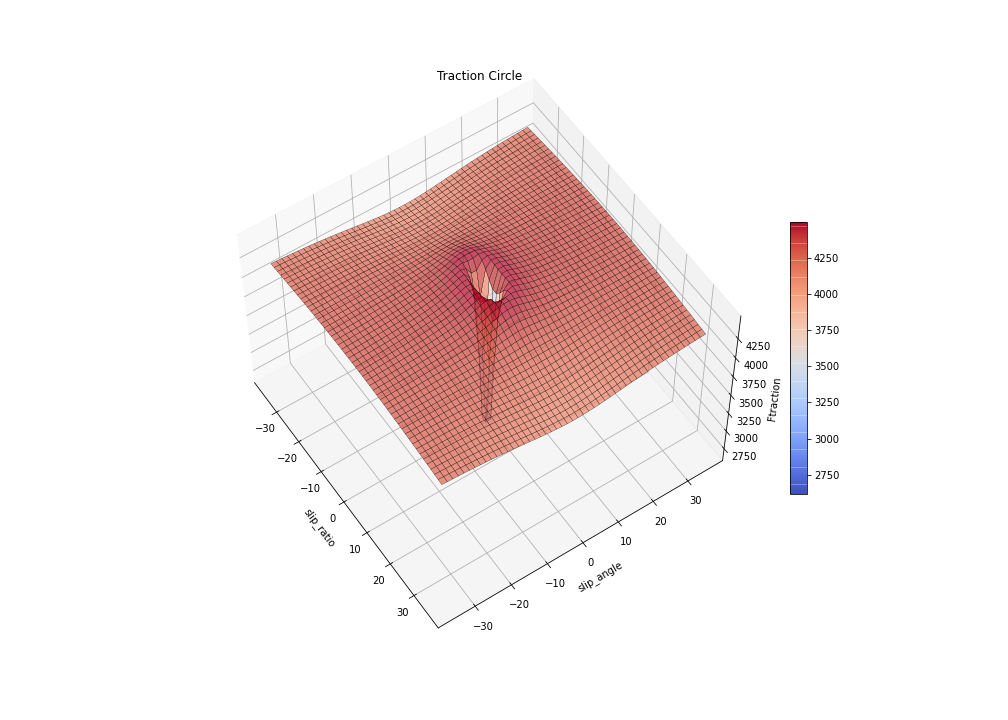

In [7]:
%matplotlib notebook
combined = np.vectorize(combinedSlip)

x = np.linspace(-35, 35)
y = np.linspace(-35, 35)
# y = np.linspace(4500, 1500, 100)
X, Y = np.meshgrid(x, y)
Z = combined(X/optimal_slip, Y/optimal_angle, W) #(X/100.0) ** 2 + (Y/90.0) ** 2
# Z = pacejkaFV(X, B, C, D * Y, E)

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14, 10))
ax.set_title('Traction Circle')
ax.set_xlabel('slip_ratio')
ax.set_ylabel('slip_angle')
# ax.invert_yaxis()
ax.set_zlabel('Ftraction')
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='k', linewidth=0.25, alpha=0.7)
# surf = ax.plot_wireframe(X, Y, Z, cmap='coolwarm')
cb = fig.colorbar(surf, shrink=0.5, aspect=16)
cb.solids.set_edgecolor('face')

plt.show()